In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm
from matplotlib import pyplot as plt

import tnetwork as tn
import tnetwork.DCD.externals
# from scipy.sparse import csr_matrix, pad

from sklearn.preprocessing import OneHotEncoder
import datetime as dt

import scipy

from networkx.algorithms.similarity import graph_edit_distance as ged
from networkx.algorithms.similarity import optimize_graph_edit_distance as oged

import distinctipy
from functools import partial


In [3]:
df = pd.read_csv("./out.mit", sep="\t| ", names=["source", "target", "weight", "timestamp"], comment="%")
print(df[["source", "target"]].max())
df


C:\Users\conta\AppData\Local\Temp\ipykernel_4904\3895145206.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./out.mit", sep="\t| ", names=["source", "target", "weight", "timestamp"], comment="%")


source    96
target    96
dtype: int64


,source,target,weight,timestamp
0,1,2,1,1095183096
1,3,4,1,1095183096
2,5,6,1,1095183096
3,7,8,1,1095183096
4,9,2,1,1095183096
...,...,...,...,...
1086399,15,11,1,1115253096
1086400,15,11,1,1115253096
1086401,15,11,1,1115253096
1086402,15,11,1,1115253096


In [4]:
df["datetime"] = df["timestamp"].map(lambda x: pd.to_datetime(x, unit="s"))

In [5]:
df

,source,target,weight,timestamp,datetime
0,1,2,1,1095183096,2004-09-14 17:31:36
1,3,4,1,1095183096,2004-09-14 17:31:36
2,5,6,1,1095183096,2004-09-14 17:31:36
3,7,8,1,1095183096,2004-09-14 17:31:36
4,9,2,1,1095183096,2004-09-14 17:31:36
...,...,...,...,...,...
1086399,15,11,1,1115253096,2005-05-05 00:31:36
1086400,15,11,1,1115253096,2005-05-05 00:31:36
1086401,15,11,1,1115253096,2005-05-05 00:31:36
1086402,15,11,1,1115253096,2005-05-05 00:31:36


[]

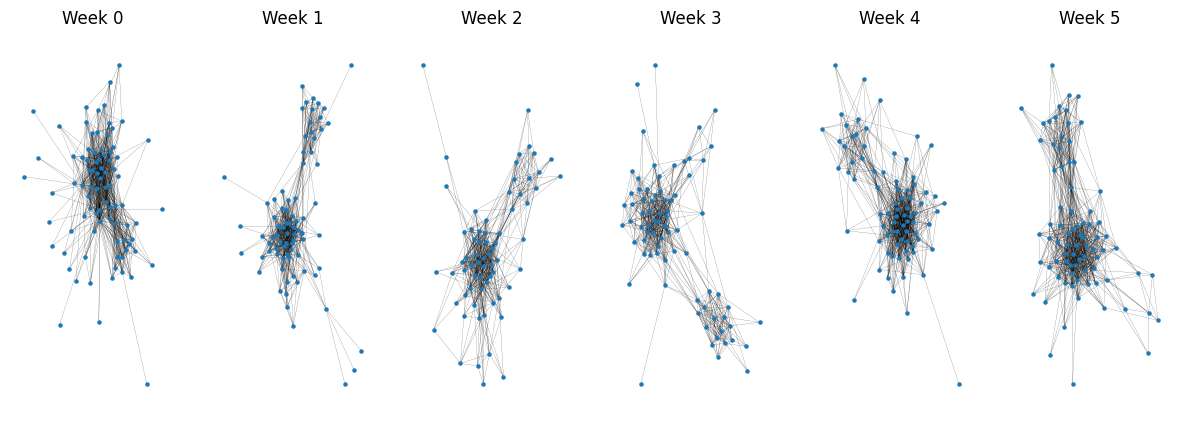

In [6]:
fig, axs = plt.subplots(1, 6, figsize=(15, 5))
first_week = df["datetime"].min()
sampling_rate =  dt.timedelta(days=7)
for i in range(len(axs)):
    snapshot = df[(first_week + sampling_rate * i <= df["datetime"]) & (df["datetime"] < first_week + sampling_rate * (i + 1))]
    G = nx.from_pandas_edgelist(snapshot)
    ax = axs[i]
    nx.draw(G, node_size=5, width=0.1, ax=ax)
    ax.set_title(f"Week {i}")
plt.plot()

In [7]:
DG = tn.DynGraphSN()
first_week = df["datetime"].min()
last_week = df["datetime"].max()
# print(n_weeks)
sampling_rate =  dt.timedelta(days=7)
n_samples = int((last_week - first_week) / sampling_rate) + 1

snapshot_i = 0
for t in tqdm(range(n_samples)):
    this_week = first_week + sampling_rate * t
    snapshot = df[(this_week <= df["datetime"]) & (df["datetime"] < this_week + sampling_rate)]
    G = nx.from_pandas_edgelist(snapshot)
    # if first_week + dt.timedelta(weeks=13) <= this_week < first_week + dt.timedelta(weeks=16):
    #     print("Skipping", t, first_week + t * sampling_rate, first_week + dt.timedelta(weeks=13), first_week + dt.timedelta(weeks=17))
    #     continue
    DG.add_snapshot(snapshot_i, G)
    snapshot_i += 1
    # if first_week + sampling_rate * t > first_week + dt.timedelta(weeks=1) * 15:
    #     break

100%|██████████| 34/34 [00:00<00:00, 52.81it/s]


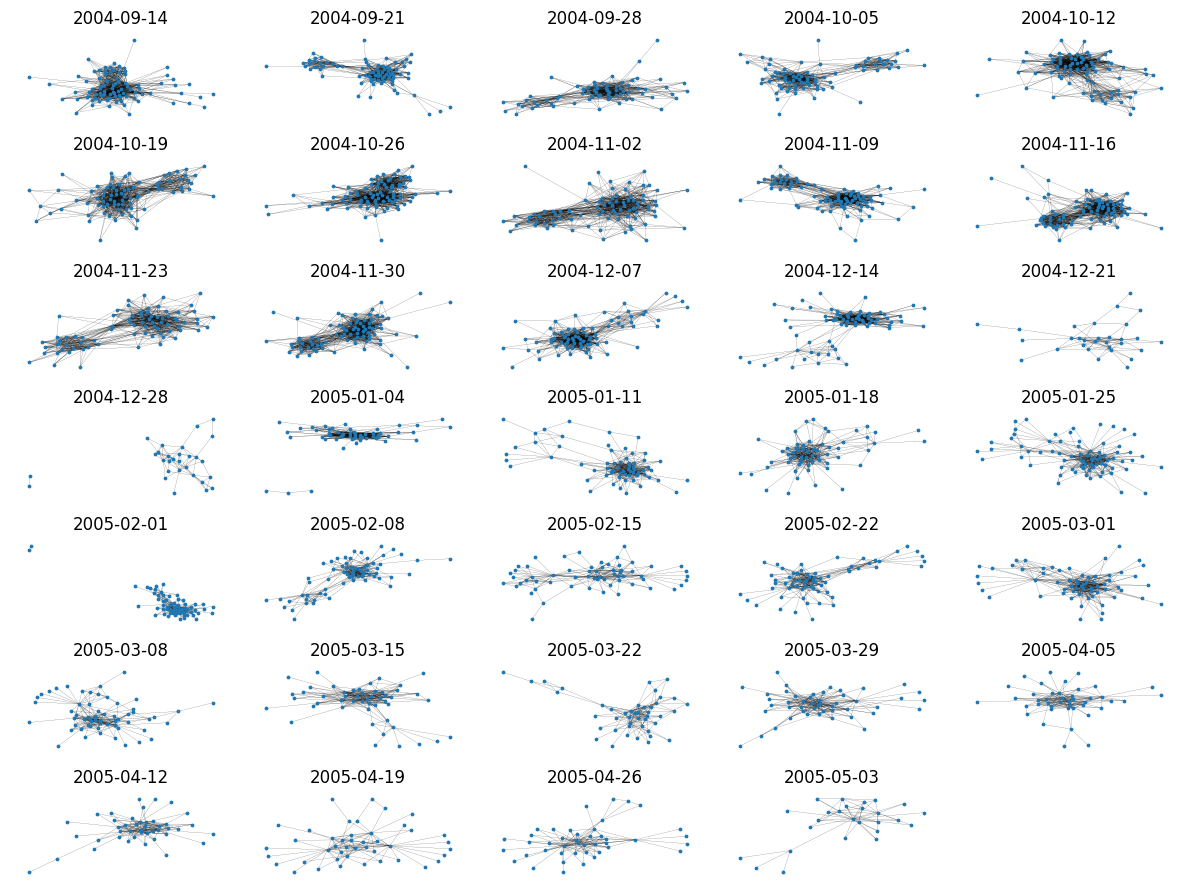

In [8]:
fig, axs = plt.subplots(7, 5, figsize=(12, 9))
axs = axs.flatten()
for i, ax in enumerate(axs):
    if i >= len(DG.snapshots_timesteps()):
        ax.axis("off")
        continue
    snapshot = DG.snapshots(i)
    nx.draw(snapshot, pos=nx.spring_layout(snapshot), node_size=3, width=0.1, ax=ax)
    ax.set_title(f"{(first_week + sampling_rate * i).strftime('%Y-%m-%d')}")

plt.tight_layout()
plt.savefig("ants.png")
# plt.close()

In [9]:
communities = tnetwork.DCD.smoothed_louvain(DG)
# communities = tnetwork.DCD.externals.estrangement_confinement(DG)


  0% (0 of 34) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


starting smoothed_louvain


 35% (12 of 34) |########                | Elapsed Time: 0:00:00 ETA:  00:00:00


c:\Users\conta\.virtualenvs\dis-7zdFBRQQ\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


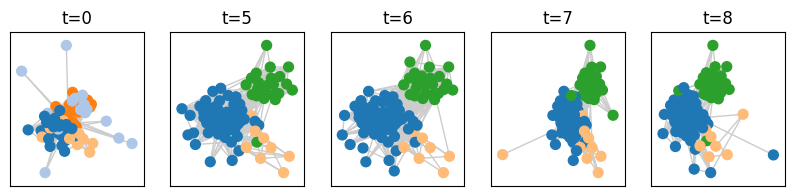

In [10]:
# better_coms = {}
# for community, value in communities.communities().items():
#     new_com = {}
#     for node_str, list_of_times in value.items():
#         node = int(node_str.replace("\\", ""))
#         for time in list_of_times:
#             if time in better_coms:
#                 if community in better_coms[time]:
#                     better_coms[time][community].append(node)
#                 else:
#                     better_coms[time][community] = [node]
#             else:
#                 better_coms[time] = {community: [node]}

# communities = tn.DynCommunitiesSN()
# for t, partition in better_coms.items():
#     communities.set_communities(t, partition)

times_to_plot = [0, 5, 6, 7, 8]

plot = tn.plot_as_graph(DG,communities,ts=times_to_plot,auto_show=True,width=200,height=200)

c:\Users\conta\.virtualenvs\dis-7zdFBRQQ\lib\site-packages\numpy\core\numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


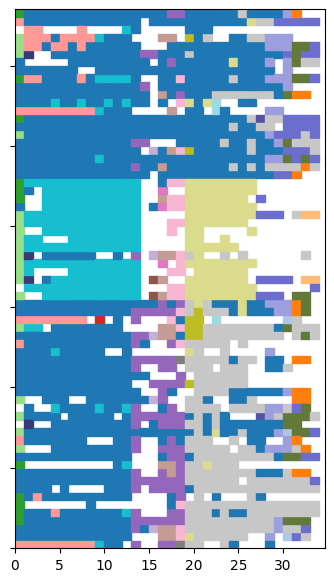

In [11]:
nodes = ([item for sublist in communities.communities(20).values() for item in sublist])
plot = tn.plot_longitudinal(DG,communities=communities,auto_show=True,width=400,height=700, nodes=nodes)


['#00ff00', '#ff00ff', '#0080ff', '#ff8000', '#80bf80', '#5407aa', '#b60217', '#f180d2', '#00ffff', '#fefd3c', '#17821f', '#00ff80', '#8be602', '#ad5666', '#80e7f3', '#8849f7', '#0f628f', '#0000ff', '#ff0080', '#6a460c', '#e0ad67', '#13185b', '#26b1b8', '#838f26', '#c6e8af', '#2ecc48', '#9995fe', '#b71ab6', '#2c40d9', '#6e77a9', '#fd2f1e', '#8000ff', '#800d5e', '#fd4e8e', '#5ffd6f', '#54495f', '#d1bd05', '#448e62', '#e1c1f3', '#e03df4', '#47fabf', '#4e0421', '#acf953', '#b73f16', '#55b901', '#010cac', '#48affa', '#193b1f', '#baa8b8', '#c67933', '#b460be', '#4dfd23', '#fedf7e', '#05c202', '#01aa75', '#833c9a', '#c71466', '#9ac23d', '#00c6ef', '#5b77f5', '#a5927b', '#fe20be', '#78b5c6', '#ff0000', '#d3f40c', '#fc613b', '#83f2a4', '#bf09fb', '#e17a75', '#01f23a', '#feb0b5', '#06e3bb', '#177ac8', '#136350', '#3e18fc', '#29319a', '#ca6ffe', '#7a21cb', '#feb229', '#c0f9fb', '#45d88d', '#03aa3d', '#516e28', '#800000', '#bdd375', '#7b736c', '#66ae49', '#fcecc4', '#893647', '#a6c3fa', '#dad33c'

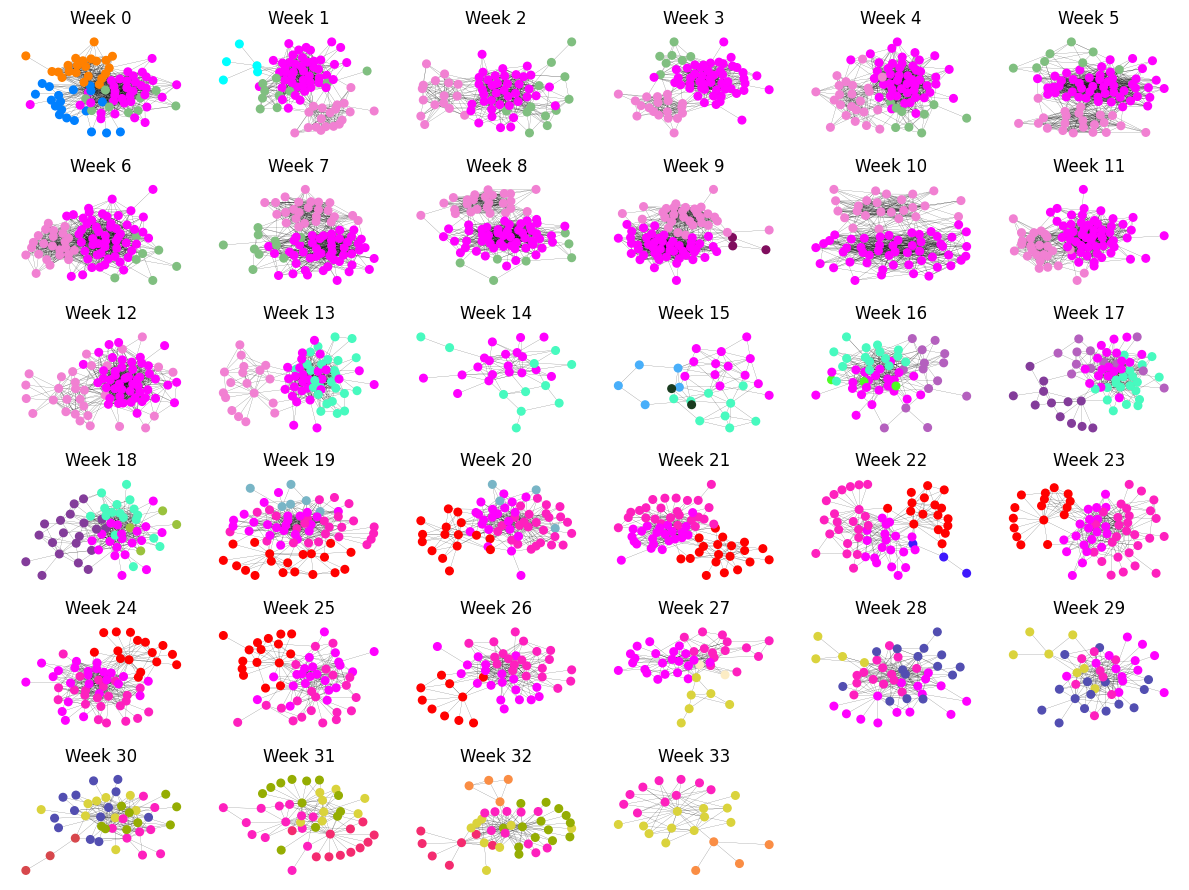

In [12]:
fig, axs = plt.subplots(6, 6, figsize=(12, 9))
axs = axs.flatten()

colors = ["red", "blue", "green", "purple", "pink", "brown", "yellow", "orange", "grey", "black", ]
colors = [distinctipy.get_hex(c) for c in distinctipy.get_colors(150)]
print(colors)

for i, ax in enumerate(axs):
    if i >= len(DG.snapshots_timesteps()):
        ax.axis("off")
        continue
    snapshot = DG.snapshots(i)
    communities_snapshot = communities.snapshots[i]

    partition_snapshot = list(map(lambda x: next(int(k) for k in communities_snapshot.keys() if x in communities_snapshot[k]), snapshot.nodes()))
    distinct_communities = list(dict.fromkeys(partition_snapshot))
    short = {k: distinct_communities.index(k) for k in distinct_communities}
    
    partition_snapshot_norm = [short[c] for c in partition_snapshot]
    try:
        coloring = [colors[x] for x in partition_snapshot]
    except IndexError:
        print(f"{i} {len(colors)} {max(partition_snapshot)}")
        raise
    nx.draw(snapshot, pos=nx.kamada_kawai_layout(snapshot), node_size=30, width=0.1, ax=ax, node_color=coloring)
    ax.set_title(f"Week {i}")

plt.tight_layout()
plt.savefig("ants.png")
# plt.close()

In [13]:
#import sparse matrix from scipy
from scipy.sparse import csr_matrix, vstack, hstack
from scipy.sparse.linalg import norm

def L2(G1, G2):
    A1 = nx.to_scipy_sparse_array(G1)
    A2 = nx.to_scipy_sparse_array(G2)

    # pad with zeros to shape 96x96    
    A1 = vstack([A1, csr_matrix((96 - A1.shape[0], A1.shape[1]))])
    A1 = hstack([A1, csr_matrix((A1.shape[0], 96 - A1.shape[1]))])

    A2 = vstack([A2, csr_matrix((96 - A2.shape[0], A2.shape[1]))])
    A2 = hstack([A2, csr_matrix((A2.shape[0], 96 - A2.shape[1]))])

    return norm(A1 - A2)

def L2_k(G1, G2, k=2):
    A1 = nx.to_scipy_sparse_array(G1)
    A2 = nx.to_scipy_sparse_array(G2)

    # pad with zeros to shape 96x96    
    A1 = vstack([A1, csr_matrix((96 - A1.shape[0], A1.shape[1]))])
    A1 = hstack([A1, csr_matrix((A1.shape[0], 96 - A1.shape[1]))])

    A2 = vstack([A2, csr_matrix((96 - A2.shape[0], A2.shape[1]))])
    A2 = hstack([A2, csr_matrix((A2.shape[0], 96 - A2.shape[1]))])
    return norm(A1**k - A2**k)


def kl_divergence(p, q):
    vec = scipy.special.rel_entr(p, q)
    vec = np.ma.masked_invalid(vec).compressed()
    kl_div = np.sum(vec)    
    return kl_div

def pagerank_kl_divergence(G1, G2):
    pr1 = nx.pagerank(G1)
    pr2 = nx.pagerank(G2)

    # pad with zeros to shape 96x96
    pr1 = np.pad(list(pr1.values()), ((0, 96 - len(pr1))), 'constant')
    pr2 = np.pad(list(pr2.values()), ((0, 96 - len(pr2))), 'constant')

    # calculate kl divergence
    kl_div = kl_divergence(pr1, pr2)

    return 1 - kl_div


def stability(DG, metric):
    values = []
    for i in (range(1, len(DG.snapshots_timesteps()))):
        G1 = DG.snapshots(i - 1)
        G2 = DG.snapshots(i)
        score = metric(G1, G2)
        values.append(score)
    return [x / max(values) for x in values]


metrics = {
    "L2": L2,
    # "L2_2": lambda x, y: L2_k(x, y, k=2),
    # "L2_3": lambda x, y: L2_k(x, y, k=3),
    # "pagerank_kl_divergence": pagerank_kl_divergence,
    "graph edit distance": lambda G1, G2: next(oged(G1, G2)),
}

scores = {}
for name, metric in metrics.items():
    scores[name] = stability(DG, metric)


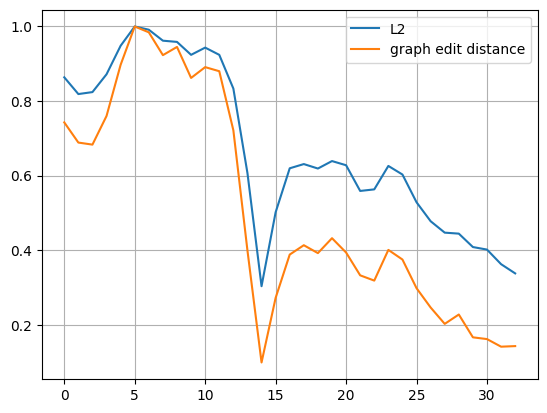

In [14]:
for name, score in scores.items():
    plt.plot(score, label=name)

plt.legend()
plt.grid()
# plt.plot(stability_scores)
plt.show()

In [29]:
def flip_partitioning(partitioning):
    nodes = [item for sublist in partitioning.values() for item in sublist]
    return dict(zip(nodes, map(lambda x: next(int(k) for k in partitioning.keys() if x in partitioning[k]), nodes)))

def estrangement(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)
    estranged = 0

    G1edges = G1.edges()

    for edge in G2.edges():
        if edge not in G1edges:
            # edges that are not in G1 are not estranged
            continue
        if C1[edge[0]] != C1[edge[1]]:
            # only edges that connected nodes in the same community can be estranged
            continue
        if C2[edge[0]] != C2[edge[1]]:
            estranged += 1
    return estranged / len(G2.edges())


def lev_trivial(a, b):
    if len(b) == 0:
        return len(a)
    if len(a) == 0:
        return len(b)
    if a[0] == b[0]:
        return lev_trivial(a[1:], b[1:])
    return 1 + min(lev_trivial(a[1:], b), lev_trivial(a, b[1:]), lev_trivial(a[1:], b[1:]))

def lev(s, t):
    m, n = len(s), len(t)
    d = np.zeros((len(s) + 1, len(t) + 1), dtype=np.int32)
    for i in range(m+1):
        d[i, 0] = i
    for j in range(n+1):
        d[0, j] = j
    for j in range(1, n + 1):
        for i in range(1, m + 1):
            if s[i - 1] == t[j - 1]:
                substitution_cost = 0
            else:
                substitution_cost = 1
            deletion_cost = d[i - 1, j] + 1
            insertion_cost = d[i, j - 1] + 1
            substitution_cost = d[i - 1, j - 1] + substitution_cost
            d[i, j] = min(deletion_cost, insertion_cost, substitution_cost)
    return d[m, n]


def lev2(s, t):
    m, n = len(s), len(t)
    
    v0 = np.arange(n + 1)
    v1 = np.zeros(n + 1)
    
    for i in range(m):

        v1[0] = i + 1

        for j in range(n):

            deletion_cost = v0[j + 1] + 1
            insertion_cost = v1[j] + 1
            if s[i] == t[j]:
                substitution_cost = v0[j]
            else:
                substitution_cost = v0[j] + 1

            v1[j + 1] = min(deletion_cost, insertion_cost, substitution_cost)

        v0, v1 = v1, v0
    return v0[n]


def levenshtein_stability(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)

    # get values sorted by key
    a = [C1[k] for k in sorted(C1.keys())]
    b = [C2[k] for k in sorted(C2.keys())]

    assert lev(a, b) == lev2(a, b), (lev(a, b), lev2(a, b))

    return lev2(a, b)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def cosine_similarity_stability(G1, G2, C1, C2):
    C1 = flip_partitioning(C1)
    C2 = flip_partitioning(C2)

    # get values sorted by key
    a = [C1[k] for k in sorted(C1.keys())]
    b = [C2[k] for k in sorted(C2.keys())]

    # pad with zeros to get same length
    if len(a) < len(b):
        a = np.pad(a, (0, len(b) - len(a)), 'constant')
    elif len(b) < len(a):
        b = np.pad(b, (0, len(a) - len(b)), 'constant')
    
    # one hot encode
    categories = np.unique(np.concatenate((a, b)))
    encoder = OneHotEncoder(categories=[categories])
    a = encoder.fit_transform(np.array(a).reshape(-1, 1)).toarray().flatten()
    b = encoder.fit_transform(np.array(b).reshape(-1, 1)).toarray().flatten()

    return cosine_similarity(a, b)


def community_stability(DG, metric, measures_instability=False, **kwargs):
    values = []
    plot = kwargs.get("plot", False)
    if plot:
        fig, axs = plt.subplots(7, 5, figsize=(16, 12))
        axs = axs.flatten()
    for i in range(1, len(DG.snapshots_timesteps())):
        G1 = DG.snapshots(i - 1)
        G2 = DG.snapshots(i)
        C1 = communities.snapshots[i - 1]
        C2 = communities.snapshots[i]
        if plot:
            score = metric(G1, G2, C1, C2, axs[i-1], **kwargs)
        else:
            score = metric(G1, G2, C1, C2, **kwargs)
        values.append(score)
    if plot:
        for i in range(len(DG.snapshots_timesteps())-1, len(axs)):
            axs[i].axis('off')
        plt.tight_layout()
        plt.show()
    if measures_instability:
        # return values
        return [1 - x / max(values) for x in values]
    else:
        return [x / max(values) for x in values]
    
metrics = {
    "estrangement": (estrangement, True),
    "levenshtein": (levenshtein_stability, True),
    "cosine similarity": (cosine_similarity_stability, False),
}
community_scores = {}
for name, (metric, instability) in metrics.items():
    community_scores[name] = community_stability(DG, metric, measures_instability=instability)


In [111]:
def eG(S, T, A):
    r = 0
    for i in S:
        for j in T:
            r += A[i-1, j-1]
    return r

def summary(G, C):
    S = nx.Graph()
    for node in C.keys():
        S.add_node(node)
    for i in range(1, max(G.nodes()) + 1):
        if i not in G.nodes():
            G.add_node(i)
    adj = nx.adjacency_matrix(G, nodelist=range(1, max(G.nodes()) + 1)).todense()
    for i in C.keys():
        for j in C.keys():
            w = eG(C[i], C[j], adj) / (len(C[i]) * len(C[j]))
            S.add_edge(i, j, weight=w)
    return S

def summary_distance(G1, G2, C1, C2, ax=None, distance_measure=None, plot=False):
    S1 = summary(G1, C1)
    S2 = summary(G2, C2)
    if plot:
        S = S2
        labels = nx.get_edge_attributes(S,'weight')
        labels = {k: f"{v:.2f}" for k, v in labels.items()}
        pos=nx.spring_layout(S)
        coloring = [colors[int(i)] for i in S.nodes()]
        nx.draw(S, pos=pos, ax=ax, node_size=150, alpha=0.2, node_color=coloring)
        nx.draw_networkx_edge_labels(S, pos=pos, edge_labels=labels, ax=ax, font_size=7)
    
    d = distance_measure(S1, S2)

    return d


# community_stability(DG, partial(summary_distance, distance_measure=ged), measures_instability=True, plot=True)
# community_stability(DG, partial(summary_distance, distance_measure=L2), measures_instability=True, plot=True)

# my_ged = lambda S1, S2: ged(S1, S2, node_substitution_cost=lambda x, y: 1, node_insertion_cost=lambda x: 1, node_deletion_cost=lambda x: 1)

community_scores |= {"summary_w_L2": community_stability(DG, partial(summary_distance, distance_measure=L2), measures_instability=True, plot=False),
# "summary_w_L2_2": community_stability(DG, partial(summary_distance, distance_measure=partial(L2_k, k=2)), measures_instability=True, plot=False),
#  "summary_w_L2_3": community_stability(DG, partial(summary_distance, distance_measure=partial(L2_k, k=3)), measures_instability=True, plot=False),
#  "summary_w_pagerank": community_stability(DG, partial(summary_distance, distance_measure=pagerank_kl_divergence), measures_instability=False, plot=False)}
# "summary_w_graph_edit_distance": community_stability(DG, partial(summary_distance, distance_measure=ged), measures_instability=False, plot=False),
}


C:\Users\conta\AppData\Local\Temp\ipykernel_28604\26593997.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G, nodelist=range(1, max(G.nodes()) + 1)).todense()


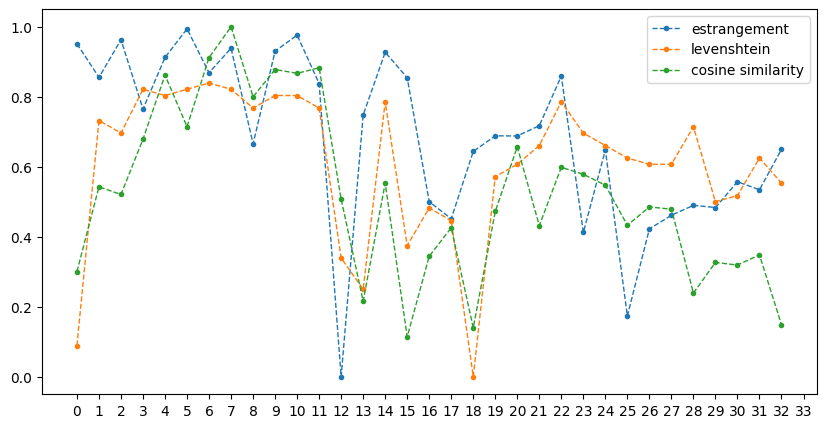

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))


for name, score in community_scores.items():

    ax.plot(score, label=name, alpha=1, linestyle="--", marker="o", markersize=3, linewidth=1)
# ax.plot(summary_scores, label="summary_distance")
# plt.plot(community_scores, label="levenshtein_stability")
# plt.ylim((0, 1.1))

plt.legend()
# plt.grid()
ax.set_xticks(range(len(DG.snapshots_timesteps())))
# plt.plot(stability_scores)
plt.show()